In [25]:
import groups

import numpy as np
import pandas as pd
import os.path as op
import re

import matplotlib.pyplot as plt
import seaborn as sns

import importlib

In [26]:
importlib.reload(groups)

<module 'groups' from 'c:\\Users\\rquax1\\Repositories\\scheduling_assistant\\groups.py'>

In [27]:
fn = op.join("data", "Balance of skills SDA 2023(1-41).xlsx")

assert op.exists(fn)

In [37]:
## here, define all column names (take them from opening the Excel and copy/paste)

col_name = 'Name2'
col_email = 'E-mail address'

cols_skills = ['Programming skills', 'Domain-specific knowledge/skills']

# should also be read from the file and stored in the dataframe, to be used later or at least included in the output of the group assignment
cols_extra = ['What is your (BSc) background? (E.g., informatics, psychobiology, ...)', 
              'Do you know what topic you\'d like to work in, if you had the choice? (E.g., climate change, financial markets, molecular biology, ...) Mention as many keywords as possible, such as multiple topics...']

col_interests = cols_extra[-1]  # this column may be used in the optimization process (textual similarity)

In [41]:
df = groups.read_student_records(fn, cols_skills, col_name=col_name, col_email=col_email,
                                 col_background=cols_extra[0], 
                                 col_interests=cols_extra[1], 
                                 to_replace=[groups._default_skill_replacement, groups._default_application_domain_expertise_replacement], verbose=1)

read_student_records: the original data contains 41 rows.
read_student_records: after dropping NaN, the data contains 41 rows.
read_student_records: after dropping email=="anonymous", the data contains 41 rows.


## Find potential duplicate names

In [42]:
from difflib import SequenceMatcher

def text_similarity(a: str, b: str) -> float:
    return SequenceMatcher(None, a, b).ratio()

In [44]:
name_sims = []  # list of (name_index1, name_index2, name1, name2, similarity-score)

names = df[col_name].to_list()

for nix1, name1 in df[col_name].iterrows():
    for nix2, name2 in df[col_name].iterrows():
        # name2 = names[nix2]
        if nix2 > nix1:  # prevent checking a name pair in both directions
            sim = text_similarity(name1, name2)

            name_sims.append((nix1, nix2, name1, name2, sim))

name_sims = list(sorted(name_sims, key=lambda tup: tup[-1], reverse=True))

# all name pairs that are very similar:
[n for n in name_sims if n[-1] > 0.6]

[(30, 36, 'Yixuan Cui', 'Yixuan Cui', 1.0)]

In [47]:
## actually REMOVE the duplicate names

for nix1, nix2, name1, name2, sim in name_sims:
    if sim > 0.6:
        if nix1 in df.index:
            df.drop(nix1, axis='index', inplace=True)
            print(f'Removed row with index={nix1}, which had {col_name}={name1}, because it was too similar to index={nix2}, {col_name}={name2} (similarity: {sim})')
        else:
            print(f'Did not remove row with index={nix1} because it no longer existed in the dataframe')

Did not remove row with index=30 because it no longer existed in the dataframe


## Make groups

In [49]:
print(f'Will make groups with {len(df)} people.')

Will make groups with 40 people.


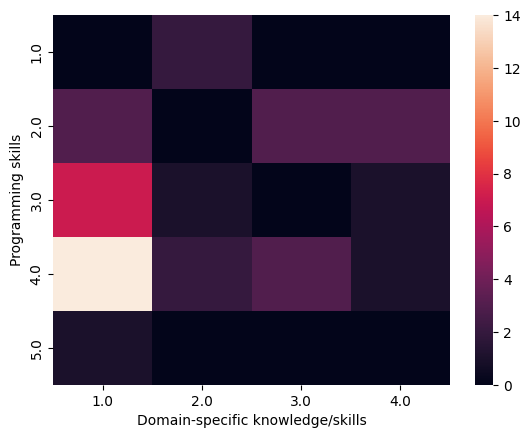

In [45]:
sns.heatmap(pd.crosstab(df[cols_skills[0]], df[cols_skills[1]]))
plt.show()

In [54]:
_target_group_size = 3

In [55]:
group_sizes = groups.infer_group_size_array(len(df), _target_group_size)

print(len(group_sizes))

group_sizes

14


[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2]

In [56]:
fitness, group_assignment = groups.optimize_assignment_for_diversity(df, cols_skills, _target_group_size, steepness=(120., 30.), max_iter=2500, max_contig_no_improvements=50, interests_weight=0.5, 
                                                                     col_interests=col_interests, verbose=1)

In [57]:
group_assignment  # solution of assignment of student indices in groups

[[12, 35],
 [33, 11, 0],
 [3, 7, 34],
 [26, 19, 38],
 [15, 22, 39],
 [24, 10, 18],
 [1, 8, 25],
 [21, 4, 40],
 [28, 20, 31],
 [9, 5, 16],
 [14, 27, 17],
 [29, 2, 13],
 [36, 32, 37],
 [6, 23]]

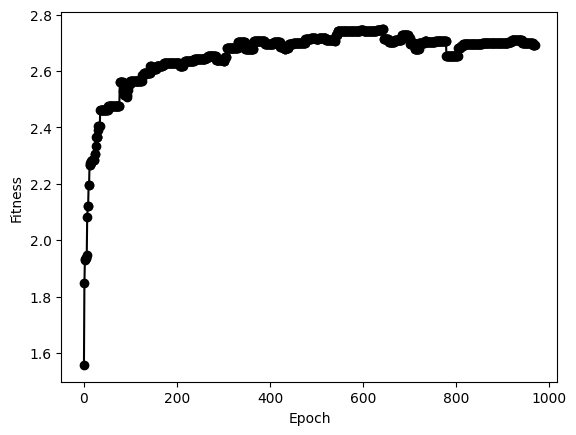

In [58]:
plt.plot(range(len(groups._fitness_over_epochs)), groups._fitness_over_epochs, '-ok')
plt.xlabel('Epoch')
plt.ylabel('Fitness')
plt.show()

In [62]:
output_dir = 'results'

In [60]:
results_label = op.basename(fn)[:op.basename(fn).index('.')].replace(' ', '_').lower()

results_label

'balance_of_skills_sda_2023(1-41)'

In [63]:
studrowix_to_groupix = dict()

for gix, stud_ixs in enumerate(group_assignment):
    with open(op.join(output_dir, f'group{gix}_{results_label}.txt'), 'w') as fout:
        print(f'\tGroup {gix}:')

        for six in stud_ixs:
            studrowix_to_groupix[six] = gix

            print(f' - Student (row {six} in data file):\n{df.loc[six, [col_name, col_email] + cols_extra]}')
            fout.write(f' - Student (row {six} in data file):\n{df.loc[six, [col_name, col_email] + cols_extra]}'.encode("ascii", "ignore").decode())

	Group 0:
 - Student (row 12 in data file):
Name2                                                                                                                                                                                                                           Leonards Leimanis
E-mail address                                                                                                                                                                                                        leonards.leimanis@gmail.com
What is your (BSc) background? (E.g., informatics, psychobiology, ...)                                                                                                                                                      Media and information
Do you know what topic you'd like to work in, if you had the choice? (E.g., climate change, financial markets, molecular biology, ...) Mention as many keywords as possible, such as multiple topics...    Financial markets, stohasti

In [64]:
df_out = df.copy(deep=True)

df_out['Group ID'] = [studrowix_to_groupix[six] for six in df_out.index]

df_out

,Programming skills,Domain-specific knowledge/skills,E-mail address,Name2,"What is your (BSc) background? (E.g., informatics, psychobiology, ...)","Do you know what topic you'd like to work in, if you had the choice? (E.g., climate change, financial markets, molecular biology, ...) Mention as many keywords as possible, such as multiple topics...",Group ID
0,4.0,1.0,stan.deutekom@student.uva.nl,Stan Deutekom,Informatics,NaN,1
1,4.0,1.0,amber.stoevelaar@student.uva.nl,Amber Stoevelaar,Bsc Informatica,"Education, medicine",6
2,4.0,3.0,jens.dijkgraaf@student.uva.nl,Jens Dijkgraaf,Informatics,"Financial markets, financials, brands",11
3,4.0,1.0,13720384@uva.nl,Annes Negmel-Din,Informatics,"Financial markets !!, money, prices, customer ...",2
4,3.0,1.0,suzefrikk003@gmail.com,Suze Frikkee,Economics with a minor in AI,Finance/agriculture/trade,7
5,4.0,2.0,svenhaar11@gmail.com,Sven Haarbrink,Mechanical Engineering,"financial markets, ecommerce applications, dat...",9
6,2.0,4.0,xiaoyao.shen@student.uva.nl,Xiaoyao Shen,Economics,financial markets,13
7,3.0,1.0,lucaskeijzer@gmail.com,Lucas Keijzer,Informatiekunde,NaN,2
8,4.0,1.0,pjotrpiet@outlook.com,Pjotr Piet,Computer science,NaN,6
9,4.0,1.0,thijs.van.solt@student.uva.nl,Thijs van solt,informatics,NaN,9


In [66]:
df_out.to_excel(op.join(output_dir, f'group_assignment_{results_label}.xlsx'))
df_out[[col_name, col_email, 'Group ID']].to_excel(op.join(output_dir, f'group_assignment_{results_label}_minimal.xlsx'))

## Tweaking

Here you can find some names or group compositions and see if you can co-locate some names, or find groups which are not diverse enough, etc.

In [19]:
def get_rows_which_contain(df, col_name: str, col_val: str):
    return df.loc[list(map(lambda name: col_val in name, df[col_name]))]

def get_rows_where_equals(df, col_name: str, col_val):
    return df.loc[df[col_name] == col_val]

In [24]:
get_rows_which_contain(df_out, 'Name', 'Elizabeth')

,Programming skills,Domain-specific knowledge/skills,Email,Name,"What is your (BSc) background? (E.g., informatics, psychobiology, ...)","Do you know what topic you'd like to work in, if you had the choice? (E.g., climate, financial markets, molecular biology, ...) If not then please leave blank.",Group ID
42,2.0,2.0,elizabeth.law@student.uva.nl,Elizabeth Law,Mathematics & Physics,NaN,0


In [20]:
get_rows_which_contain(df_out, 'Name', 'Paul')

,Programming skills,Domain-specific knowledge/skills,Email,Name,"What is your (BSc) background? (E.g., informatics, psychobiology, ...)","Do you know what topic you'd like to work in, if you had the choice? (E.g., climate, financial markets, molecular biology, ...) If not then please leave blank.",Group ID
5,2.0,4.0,paul.hosek@student.uva.nl,Paul Hosek,Brain and Cognitive Science,"climate, very exited about the Ising model app...",7


In [21]:
get_rows_which_contain(df_out, 'Name', 'Nik')

,Programming skills,Domain-specific knowledge/skills,Email,Name,"What is your (BSc) background? (E.g., informatics, psychobiology, ...)","Do you know what topic you'd like to work in, if you had the choice? (E.g., climate, financial markets, molecular biology, ...) If not then please leave blank.",Group ID
4,3.0,4.0,niklas.schaaf@student.uva.nl,Niklas Schaaf,geoscience,"climate, potentially the application of the Is...",7


### Compare two groups

In [23]:
get_rows_where_equals(df_out, 'Group ID', 6)

,Programming skills,Domain-specific knowledge/skills,Email,Name,"What is your (BSc) background? (E.g., informatics, psychobiology, ...)","Do you know what topic you'd like to work in, if you had the choice? (E.g., climate, financial markets, molecular biology, ...) If not then please leave blank.",Group ID
46,4.0,2.0,abandhoe@hotmail.com,Akash Bandhoe,Physics and astronomy,molecular biology,6
53,5.0,2.0,seda.denboer@student.uva.nl,Seda den Boer,Physics & astronomy,"Physics but also okay with climate, biology or...",6
72,3.0,5.0,maximzewe@gmail.com,Maxim Zewe,"Liberal Arts & Science (major in physics, math...","I like networks of neurons, but I do not have ...",6
77,3.0,2.0,reinoutmensing@gmail.com,Reinout mensing,Physics and astronomy,NaN,6
